In [ ]:
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
from matplotlib import pyplot as plt
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import (
    impute,
    make_forecasting_frame,
    roll_time_series,
)

In [ ]:
df = pd.read_csv("train.csv")
df["service_date"] = pd.to_datetime(df["service_date"])
df = df.drop("index", axis=1)
# df = df.set_index("service_date")

In [ ]:
df

,service_date,service_status,sum_price,hotel_id,hotel_category_star,hotel_max_rooms,hotel_type,city_name,region_name,country_name
0,2018-10-03,"Аннулировано, без штрафа",5117.000000,1037,4.0,74.0,hotel,Якутск,Якутия,Россия
1,2019-04-02,Подтвержден,2850.899902,5222,0.0,15.0,mini-hotel,Белгород,Белгородская область,Россия
2,2023-09-28,Подтвержден,3700.000000,35751,3.0,16.0,hotel,Жуковский,Московская область,Россия
3,2019-04-27,Подтвержден,15603.200195,2428,2.0,37.0,hotel,Казань,Татарстан,Россия
4,2023-04-08,Подтвержден,5915.000000,103399,3.0,105.0,hotel,Краснодар,Краснодарский край,Россия
...,...,...,...,...,...,...,...,...,...,...
5408815,2020-11-24,Подтвержден,12320.000000,2267,3.0,74.0,hotel,Туапсе,Краснодарский край,Россия
5408816,2023-02-13,Подтвержден,3288.250000,3257,3.0,66.0,hotel,Черкесск,Карачаево-Черкессия,Россия
5408817,2022-09-26,Подтвержден,506.000000,13935,0.0,7.0,hostel,Уфа,Башкортостан,Россия
5408818,2022-06-06,Подтвержден,2500.000000,130933,3.0,26.0,hotel,Тверь,Тверская область,Россия


In [ ]:
(df["sum_price"] < 0).sum()

3

In [ ]:
df["sum_price"] = df["sum_price"].apply(lambda x: abs(x))

In [ ]:
train = df.groupby(["service_date"])["sum_price"].sum()
train

service_date
2011-09-06    6.800000e+03
2011-09-13    6.741000e+03
2012-01-27    7.360000e+03
2012-02-13    3.776000e+04
2012-03-02    2.400000e+03
                  ...     
2024-05-27    1.007527e+08
2024-05-28    1.003180e+08
2024-05-29    9.832966e+07
2024-05-30    1.000403e+08
2024-05-31    9.813730e+07
Name: sum_price, Length: 4203, dtype: float64

<Axes: xlabel='service_date'>

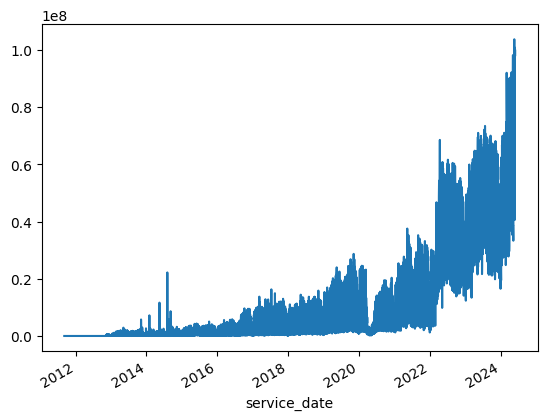

In [ ]:
train.plot()

<Axes: xlabel='service_date'>

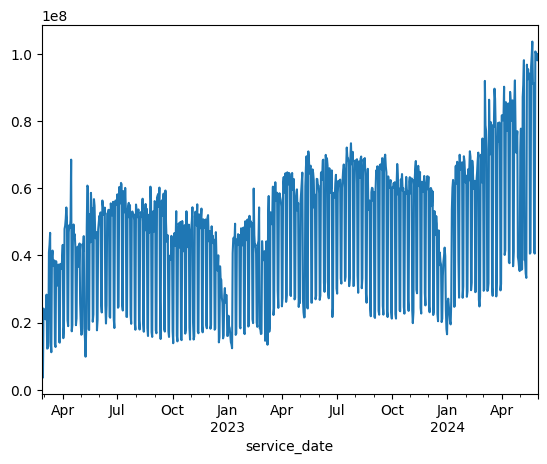

In [ ]:
train_after_covid = train[train.index > "2022-02-24"]
train_after_covid.plot()

In [ ]:
# годовая и недельная сезонность
# ещё присутствует тренд, похоже на мультипликативный

In [ ]:
train_after_covid = train_after_covid.reset_index()

In [ ]:
train_after_covid.columns = ["date", "forecast_value"]

In [ ]:
submission = pd.read_csv("sample_submission.csv")
train_after_covid = pd.concat([train_after_covid, submission], axis=0)

In [ ]:
train_after_covid = train_after_covid.reset_index(drop=True)
train_after_covid["date"] = pd.to_datetime(train_after_covid["date"])

train_after_covid = train_after_covid.sort_values(by="date")

In [ ]:
def create_date_features(df):
    df = df.copy()
    df["month"] = df.date.dt.month.astype("int8")
    df["day_of_month"] = df.date.dt.day.astype("int8")
    df["day_of_year"] = df.date.dt.dayofyear.astype("int16")
    df["week_of_month"] = (df.date.apply(lambda d: (d.day - 1) // 7 + 1)).astype("int8")
    df["week_of_year"] = (df.date.dt.isocalendar().week).astype("int8")
    df["day_of_week"] = (df.date.dt.dayofweek + 1).astype("int8")
    df["year"] = df.date.dt.year.astype("int32")
    df["is_wknd"] = (df.date.dt.weekday // 4).astype("int8")
    df["quarter"] = df.date.dt.quarter.astype("int8")
    df["is_month_start"] = df.date.dt.is_month_start.astype("int8")
    df["is_month_end"] = df.date.dt.is_month_end.astype("int8")
    df["is_quarter_start"] = df.date.dt.is_quarter_start.astype("int8")
    df["is_quarter_end"] = df.date.dt.is_quarter_end.astype("int8")
    df["is_year_start"] = df.date.dt.is_year_start.astype("int8")
    df["is_year_end"] = df.date.dt.is_year_end.astype("int8")
    # 0: Winter - 1: Spring - 2: Summer - 3: Fall
    df["season"] = np.where(df.month.isin([12, 1, 2]), 0, 1)
    df["season"] = np.where(df.month.isin([6, 7, 8]), 2, df["season"])
    df["season"] = pd.Series(
        np.where(df.month.isin([9, 10, 11]), 3, df["season"])
    ).astype("int8")
    return df


train_after_covid_with_features = create_date_features(train_after_covid)

In [ ]:
lag = 30
test = train_after_covid.copy()
test["forecast_value"] = test["forecast_value"].shift(lag)
test = test.loc[lag:]
test["id"] = 1

temp = roll_time_series(
    test,
    column_id="id",
    column_sort="date",
    max_timeshift=30,
    min_timeshift=5,
    rolling_direction=1,
)

temp

Rolling: 100%|██████████| 40/40 [00:00<00:00, 126.60it/s]


,date,forecast_value,id
3861,2022-03-27,2.784901e+07,"(1, 2022-04-01 00:00:00)"
3862,2022-03-28,4.872699e+06,"(1, 2022-04-01 00:00:00)"
3863,2022-03-29,3.604619e+06,"(1, 2022-04-01 00:00:00)"
3864,2022-03-30,2.415991e+07,"(1, 2022-04-01 00:00:00)"
3865,2022-03-31,2.112790e+07,"(1, 2022-04-01 00:00:00)"
...,...,...,...
23850,2024-06-26,1.007527e+08,"(1, 2024-06-30 00:00:00)"
23851,2024-06-27,1.003180e+08,"(1, 2024-06-30 00:00:00)"
23852,2024-06-28,9.832966e+07,"(1, 2024-06-30 00:00:00)"
23853,2024-06-29,1.000403e+08,"(1, 2024-06-30 00:00:00)"


In [ ]:
features = extract_features(
    temp, column_id="id", column_sort="date", impute_function=impute
)

Feature Extraction: 100%|██████████| 40/40 [00:14<00:00,  2.81it/s]


In [ ]:
features = features.reset_index(level=0, drop=True)

In [ ]:
features

,forecast_value__variance_larger_than_standard_deviation,forecast_value__has_duplicate_max,forecast_value__has_duplicate_min,forecast_value__has_duplicate,forecast_value__sum_values,forecast_value__abs_energy,forecast_value__mean_abs_change,forecast_value__mean_change,forecast_value__mean_second_derivative_central,forecast_value__median,...,forecast_value__fourier_entropy__bins_5,forecast_value__fourier_entropy__bins_10,forecast_value__fourier_entropy__bins_100,forecast_value__permutation_entropy__dimension_3__tau_1,forecast_value__permutation_entropy__dimension_4__tau_1,forecast_value__permutation_entropy__dimension_5__tau_1,forecast_value__permutation_entropy__dimension_6__tau_1,forecast_value__permutation_entropy__dimension_7__tau_1,forecast_value__query_similarity_count__query_None__threshold_0.0,forecast_value__mean_n_absolute_max__number_of_maxima_7
2022-04-01,1.0,0.0,0.0,0.0,1.028132e+08,2.291793e+15,9.580565e+06,-1.329995e+06,2.880931e+06,2.116347e+07,...,1.039721,1.386294,1.386294,1.386294,1.098612,0.693147,-0.000000,3.218876,0.0,6.003628e+07
2022-04-02,1.0,0.0,0.0,0.0,1.242863e+08,2.752889e+15,8.029490e+06,-1.062643e+06,2.325043e+06,2.119904e+07,...,1.386294,1.386294,1.386294,1.609438,1.386294,1.098612,0.693147,-0.000000,0.0,6.003628e+07
2022-04-03,1.0,0.0,0.0,0.0,1.452137e+08,3.190843e+15,6.960392e+06,-9.888096e+05,1.869209e+06,2.116347e+07,...,1.332179,1.332179,1.609438,1.791759,1.609438,1.386294,1.098612,0.693147,0.0,2.022987e+07
2022-04-04,1.0,0.0,0.0,0.0,1.735163e+08,3.991880e+15,7.012249e+06,5.669703e+04,2.167968e+06,2.119904e+07,...,1.332179,1.332179,1.609438,1.747868,1.791759,1.609438,1.386294,1.098612,0.0,2.357699e+07
2022-04-05,1.0,0.0,0.0,0.0,1.857535e+08,4.141628e+15,8.018156e+06,-1.734648e+06,4.319315e+05,2.116347e+07,...,1.242453,1.242453,1.791759,1.732868,1.945910,1.791759,1.609438,1.386294,0.0,2.357699e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-26,1.0,0.0,0.0,0.0,2.085018e+09,1.637239e+17,1.898298e+07,7.925592e+05,1.684093e+06,7.697594e+07,...,0.688567,1.229919,2.426015,1.717234,2.453151,2.885083,2.884863,2.941617,0.0,9.864694e+07
2024-06-27,1.0,0.0,0.0,0.0,2.108360e+09,1.678623e+17,1.774884e+07,2.026698e+06,1.287409e+04,7.775479e+07,...,0.688567,1.127483,2.426015,1.737664,2.453151,2.833739,2.831544,2.886165,0.0,9.934079e+07
2024-06-28,1.0,0.0,0.0,0.0,2.167173e+09,1.759695e+17,1.777574e+07,1.999801e+06,2.072621e+03,8.718191e+07,...,0.688567,1.127483,2.479956,1.737664,2.453151,2.833739,2.831544,2.886165,0.0,9.964225e+07
2024-06-29,1.0,0.0,0.0,0.0,2.228877e+09,1.845079e+17,1.776247e+07,2.127107e+06,4.497562e+04,9.083266e+07,...,0.822265,1.037392,2.393312,1.716233,2.521349,2.833739,2.831544,2.886165,0.0,1.001041e+08


,forecast_value
date,
2022-04-01,4.313075e+07
2022-04-02,1.533812e+07
2022-04-03,1.874454e+07
2022-04-04,4.787077e+07
2022-04-05,4.881832e+07
...,...
2024-05-27,1.007527e+08
2024-05-28,1.003180e+08
2024-05-29,9.832966e+07


date
2022-04-01    4.313075e+07
2022-04-02    1.533812e+07
2022-04-03    1.874454e+07
2022-04-04    4.787077e+07
2022-04-05    4.881832e+07
                  ...     
2024-05-27    1.007527e+08
2024-05-28    1.003180e+08
2024-05-29    9.832966e+07
2024-05-30    1.000403e+08
2024-05-31    9.813730e+07
Name: forecast_value, Length: 792, dtype: float64

In [ ]:
select_features(
    features[:-30], train_after_covid[35:-30].set_index("date")["forecast_value"]
)

,"forecast_value__cwt_coefficients__coeff_4__w_2__widths_(2, 5, 10, 20)","forecast_value__cwt_coefficients__coeff_8__w_2__widths_(2, 5, 10, 20)","forecast_value__fft_coefficient__attr_""angle""__coeff_5","forecast_value__cwt_coefficients__coeff_11__w_2__widths_(2, 5, 10, 20)","forecast_value__cwt_coefficients__coeff_5__w_2__widths_(2, 5, 10, 20)",forecast_value__energy_ratio_by_chunks__num_segments_10__segment_focus_3,"forecast_value__cwt_coefficients__coeff_12__w_2__widths_(2, 5, 10, 20)","forecast_value__change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.2","forecast_value__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""min""","forecast_value__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.2",...,"forecast_value__change_quantiles__f_agg_""mean""__isabs_True__qh_0.4__ql_0.2","forecast_value__linear_trend__attr_""slope""","forecast_value__fft_coefficient__attr_""angle""__coeff_13","forecast_value__cwt_coefficients__coeff_1__w_5__widths_(2, 5, 10, 20)",forecast_value__ar_coefficient__coeff_6__k_10,forecast_value__number_cwt_peaks__n_1,"forecast_value__change_quantiles__f_agg_""var""__isabs_True__qh_0.4__ql_0.0",forecast_value__large_standard_deviation__r_0.30000000000000004,forecast_value__autocorrelation__lag_5,forecast_value__fourier_entropy__bins_10
2022-04-01,2.949159e+07,4.265011e+06,-0.038684,3.854515e+06,2.791148e+07,0.254692,5.514616e+06,1.042878e+14,1.534792e+07,1.034655e+14,...,0.000000e+00,1.030601e+06,-0.951108,1.992133e+07,-0.061257,1.0,0.000000e+00,1.0,0.492809,1.386294
2022-04-02,3.015697e+07,4.265011e+06,-0.038684,3.854515e+06,2.939672e+07,0.212032,5.514616e+06,2.289011e+12,1.534792e+07,1.823768e+12,...,0.000000e+00,1.108871e+06,-0.951108,2.501773e+07,-0.061257,1.0,0.000000e+00,1.0,-0.084174,1.386294
2022-04-03,1.275698e+07,4.265011e+06,-0.038684,3.854515e+06,2.762228e+07,0.182930,5.514616e+06,1.739698e+12,1.534792e+07,1.430889e+12,...,0.000000e+00,1.003594e+06,-0.951108,2.319264e+07,-0.061257,1.0,0.000000e+00,1.0,-0.263954,1.332179
2022-04-04,1.096676e+07,1.531565e+07,-0.038684,3.854515e+06,2.113938e+07,0.146222,5.514616e+06,1.210660e+13,1.534792e+07,7.687007e+12,...,0.000000e+00,1.379241e+06,-0.951108,2.716725e+07,-0.061257,1.0,0.000000e+00,1.0,0.010623,1.332179
2022-04-05,7.146776e+06,2.034501e+07,0.000000,3.854515e+06,1.193394e+07,0.140935,5.514616e+06,4.972848e+13,1.534792e+07,3.287788e+13,...,0.000000e+00,6.189530e+05,-0.951108,2.423466e+07,-0.061257,2.0,0.000000e+00,1.0,-0.036006,1.242453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-27,-6.627237e+06,1.640964e+07,-33.527724,-2.445600e+07,1.978796e+07,0.094039,8.548083e+06,2.054724e+14,2.405341e+07,1.513564e+14,...,3.175186e+06,3.189185e+05,-157.794195,2.670057e+07,-1.068044,8.0,2.473673e+14,1.0,-0.374984,0.918046
2024-05-28,3.556611e+07,-1.965742e+07,17.413303,8.548083e+06,5.053382e+07,0.122921,3.386117e+07,3.281492e+14,3.154519e+07,2.239910e+14,...,2.576328e+06,1.915544e+05,-14.620925,2.436731e+07,-1.121920,9.0,3.063387e+14,1.0,-0.418912,0.918046
2024-05-29,6.574933e+07,-3.832757e+07,80.111948,3.386117e+07,5.216044e+07,0.124440,3.432744e+07,3.799710e+14,3.178147e+07,2.456802e+14,...,1.129697e+07,5.489377e+04,128.930701,2.475676e+07,-0.864190,8.0,1.374702e+14,1.0,-0.420480,0.918046
2024-05-30,5.802312e+07,-2.440618e+07,135.561653,3.432744e+07,2.197614e+07,0.128455,8.332224e+06,3.799710e+14,3.356164e+07,2.456802e+14,...,1.129697e+07,-3.834367e+05,-84.271369,4.184911e+07,-0.914718,8.0,1.372768e+14,1.0,-0.400321,1.037392


In [ ]:
# y =
y

,date,forecast_value
35,2022-04-01,4.313075e+07
36,2022-04-02,1.533812e+07
37,2022-04-03,1.874454e+07
38,2022-04-04,4.787077e+07
39,2022-04-05,4.881832e+07
...,...,...
822,2024-05-27,1.007527e+08
823,2024-05-28,1.003180e+08
824,2024-05-29,9.832966e+07
825,2024-05-30,1.000403e+08


forecast_value__variance_larger_than_standard_deviation  \
1 2022-04-01                                                1.0         
  2022-04-02                                                1.0         
  2022-04-03                                                1.0         
  2022-04-04                                                1.0         
  2022-04-05                                                1.0         
...                                                         ...         
  2024-05-27                                                1.0         
  2024-05-28                                                1.0         
  2024-05-29                                                1.0         
  2024-05-30                                                1.0         
  2024-05-31                                                1.0         

              forecast_value__has_duplicate_max  \
1 2022-04-01                                0.0   
  2022-04-02                                0.0   
  2022-04-03                                0.0   
  2022-04-04                                0.0   
  2022-04-05                                0.0   
...                                         ...   
  2024-05-27                                0.0   
  2024-05-28                                0.0   
  2024-05-29                                0.0   
  2024-05-30                                0.0   
  2024-05-31                                0.0   

              forecast_value__has_duplicate_min  \
1 2022-04-01                                0.0   
  2022-04-02                                0.0   
  2022-04-03                                0.0   
  2022-04-04                                0.0   
  2022-04-05                                0.0   
...                                         ...   
  2024-05-27                                0.0   
  2024-05-28                                0.0   
  2024-05-29                                0.0   
  2024-05-30                                0.0   
  2024-05-31                                0.0   

              forecast_value__has_duplicate  forecast_value__sum_values  \
1 2022-04-01                            0.0                1.028132e+08   
  2022-04-02                            0.0                1.242863e+08   
  2022-04-03                            0.0                1.452137e+08   
  2022-04-04                            0.0                1.735163e+08   
  2022-04-05                            0.0                1.857535e+08   
...                                     ...                         ...   
  2024-05-27                            0.0                2.182191e+09   
  2024-05-28                            0.0                2.142110e+09   
  2024-05-29                            0.0                2.103686e+09   
  2024-05-30                            0.0                2.110337e+09   
  2024-05-31                            0.0                2.114149e+09   

              forecast_value__abs_energy  forecast_value__mean_abs_change  \
1 2022-04-01                2.291793e+15                     9.580565e+06   
  2022-04-02                2.752889e+15                     8.029490e+06   
  2022-04-03                3.190843e+15                     6.960392e+06   
  2022-04-04                3.991880e+15                     7.012249e+06   
  2022-04-05                4.141628e+15                     8.018156e+06   
...                                  ...                              ...   
  2024-05-27                1.663176e+17                     1.573217e+07   
  2024-05-28                1.615433e+17                     1.688618e+07   
  2024-05-29                1.571209e+17                     1.535278e+07   
  2024-05-30                1.575585e+17                     1.535837e+07   
  2024-05-31                1.578133e+17                     1.371781e+07   

              forecast_value__mean_change  \
1 2022-04-01                -1.329995e+0

In [ ]:
temp["id"].value_counts()

id
(1, 2023-05-17 00:00:00)    31
(1, 2023-10-06 00:00:00)    31
(1, 2023-09-26 00:00:00)    31
(1, 2023-09-27 00:00:00)    31
(1, 2023-09-28 00:00:00)    31
                            ..
(1, 2022-04-05 00:00:00)    10
(1, 2022-04-04 00:00:00)     9
(1, 2022-04-03 00:00:00)     8
(1, 2022-04-02 00:00:00)     7
(1, 2022-04-01 00:00:00)     6
Name: count, Length: 822, dtype: int64

In [ ]:
test_training = train_after_covid.copy()
test_training["id"] = 1
df_rolled = roll_time_series(
    test_training["forecast_value"].shift(30).loc[30:],
    column_id="id",
    column_sort="date",
    max_timeshift=30,
    min_timeshift=5,
    rolling_direction=1,
)

df_rolled.head(35)

In [ ]:
def create_rolling_features(df, column, lags, windows):
    df = df.copy()
    for lag in lags:
        lagged_col = df[column].shift(lag)

        # df[f'lag_{lag}'] = lagged_col

        for window in windows:

            df[f"rolling_mean_lag{lag}_win{window}"] = lagged_col.rolling(
                window=window
            ).mean()
            df[f"rolling_median_lag{lag}_win{window}"] = lagged_col.rolling(
                window=window
            ).median()

            # # Min and Max
            # df[f'rolling_min_lag{lag}_win{window}'] = lagged_col.rolling(window=window).min()
            # df[f'rolling_max_lag{lag}_win{window}'] = lagged_col.rolling(window=window).max()

            # # Standard Deviation
            # df[f'rolling_std_lag{lag}_win{window}'] = lagged_col.rolling(window=window).std()

            # # Skewness
            # df[f'rolling_skew_lag{lag}_win{window}'] = lagged_col.rolling(window=window).skew()

            # Percentiles
            df[f"rolling_10th_percentile_lag{lag}_win{window}"] = lagged_col.rolling(
                window=window
            ).quantile(0.1)
            df[f"rolling_90th_percentile_lag{lag}_win{window}"] = lagged_col.rolling(
                window=window
            ).quantile(0.9)

    return df


lags = [31, 38, 45]
windows = [7, 14, 21, 28, 35, 42]


# lags = [30, 31, 38, 45, 60, 61]
# windows = [7, 14, 21, 28, 35, 42, 30, 31]

In [ ]:
catboost_train = create_rolling_features(
    train_after_covid_with_features, "forecast_value", lags, windows
)[max(lags) + max(windows) - 1 :]
catboost_train

,date,forecast_value,month,day_of_month,day_of_year,week_of_month,week_of_year,day_of_week,year,is_wknd,...,rolling_10th_percentile_lag45_win28,rolling_90th_percentile_lag45_win28,rolling_mean_lag45_win35,rolling_median_lag45_win35,rolling_10th_percentile_lag45_win35,rolling_90th_percentile_lag45_win35,rolling_mean_lag45_win42,rolling_median_lag45_win42,rolling_10th_percentile_lag45_win42,rolling_90th_percentile_lag45_win42
86,2022-05-22,2.241554e+07,5,22,142,4,20,7,2022,1,...,1.384560e+07,4.815504e+07,3.135027e+07,3.681730e+07,1.279643e+07,4.740837e+07,2.908442e+07,3.295337e+07,1.236471e+07,4.635636e+07
87,2022-05-23,5.675342e+07,5,23,143,4,21,1,2022,0,...,1.384560e+07,4.944417e+07,3.222038e+07,3.721944e+07,1.279643e+07,4.843930e+07,2.964471e+07,3.534946e+07,1.236471e+07,4.775517e+07
88,2022-05-24,5.472928e+07,5,24,144,4,21,2,2022,0,...,1.384560e+07,4.944417e+07,3.200158e+07,3.721944e+07,1.279643e+07,4.843930e+07,3.002023e+07,3.534946e+07,1.273490e+07,4.775517e+07
89,2022-05-25,4.623832e+07,5,25,145,4,21,3,2022,0,...,1.417467e+07,4.944417e+07,3.219280e+07,3.721944e+07,1.314769e+07,4.843930e+07,3.038512e+07,3.534946e+07,1.297654e+07,4.775517e+07
90,2022-05-26,4.511716e+07,5,26,146,4,21,4,2022,0,...,1.417467e+07,4.944417e+07,3.318088e+07,3.724926e+07,1.369319e+07,4.843930e+07,3.092676e+07,3.588089e+07,1.297654e+07,4.777454e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
852,2024-06-26,0.000000e+00,6,26,178,4,26,3,2024,0,...,3.557547e+07,8.933593e+07,6.455499e+07,7.697594e+07,3.581657e+07,8.808945e+07,6.561691e+07,7.741364e+07,3.604056e+07,8.854322e+07
853,2024-06-27,0.000000e+00,6,27,179,4,26,4,2024,0,...,3.557547e+07,9.122084e+07,6.487433e+07,7.697594e+07,3.581657e+07,8.997739e+07,6.597823e+07,7.741364e+07,3.604056e+07,9.008005e+07
854,2024-06-28,0.000000e+00,6,28,180,4,26,5,2024,1,...,3.557547e+07,9.220329e+07,6.519542e+07,7.697594e+07,3.581657e+07,9.160901e+07,6.623021e+07,7.741364e+07,3.604056e+07,9.077280e+07
855,2024-06-29,0.000000e+00,6,29,181,5,26,6,2024,1,...,3.557547e+07,9.330593e+07,6.572081e+07,7.697594e+07,3.581657e+07,9.228001e+07,6.659291e+07,7.741364e+07,3.604056e+07,9.199718e+07


In [ ]:
X_train = catboost_train[: -len(submission)].drop("forecast_value", axis=1)
y_train = catboost_train[: -len(submission)]["forecast_value"]
X_test = catboost_train[-len(submission) :].drop("forecast_value", axis=1)

In [ ]:
model = CatBoostRegressor(iterations=1000)

model.fit(X_train, y_train)


pred = model.predict(X_test)

Learning rate set to 0.039049
0:	learn: 19586796.4594891	total: 73.6ms	remaining: 1m 13s
1:	learn: 19071673.8604530	total: 77.2ms	remaining: 38.5s
2:	learn: 18573480.4085484	total: 80.3ms	remaining: 26.7s
3:	learn: 18106242.3118983	total: 83.3ms	remaining: 20.7s
4:	learn: 17655460.8631076	total: 86.2ms	remaining: 17.2s
5:	learn: 17233239.3546914	total: 89.2ms	remaining: 14.8s
6:	learn: 16809290.4706035	total: 92.3ms	remaining: 13.1s
7:	learn: 16372724.1737617	total: 95.2ms	remaining: 11.8s
8:	learn: 15985143.3999109	total: 98.7ms	remaining: 10.9s
9:	learn: 15606835.7953057	total: 102ms	remaining: 10.1s
10:	learn: 15252647.6148293	total: 105ms	remaining: 9.4s
11:	learn: 14922392.8010616	total: 108ms	remaining: 8.87s
12:	learn: 14579041.7249734	total: 111ms	remaining: 8.45s
13:	learn: 14248018.4821402	total: 114ms	remaining: 8.05s
14:	learn: 13940859.1748032	total: 117ms	remaining: 7.7s
15:	learn: 13668314.3501367	total: 121ms	remaining: 7.42s
16:	learn: 13394784.8300283	total: 124ms	rem

In [ ]:
model.feature_importances_

array([2.35442763e+00, 9.85688106e-01, 3.76228458e-01, 3.17859390e+00,
       5.32667668e-02, 1.80433568e+00, 6.29057513e+01, 9.38879440e-01,
       2.44752618e-01, 6.01859025e-01, 2.69614188e-02, 4.01412252e-03,
       0.00000000e+00, 0.00000000e+00, 7.39859291e-04, 9.50706030e-06,
       1.24014200e+00, 1.06372915e-01, 3.59468685e-01, 2.10315142e-01,
       5.04690541e-01, 1.45457252e-01, 6.76359102e-02, 5.32226965e-01,
       6.44581137e-01, 2.12080841e-01, 2.54088887e-01, 5.42406820e-01,
       4.98574382e-01, 2.28988451e-01, 1.15210231e-01, 5.65780188e-01,
       2.60939229e-01, 3.74400331e-01, 3.88131612e-01, 5.15402502e-01,
       2.46595573e-01, 2.10224136e-01, 8.74444333e-01, 2.50652745e-01,
       2.89552566e-01, 2.77359011e-01, 4.81534034e-01, 4.56675837e-01,
       3.59718309e-01, 4.31359194e-01, 6.55818331e-02, 4.31970239e-01,
       1.05951697e+00, 5.95510490e-02, 3.29840311e-01, 1.75947449e-01,
       4.80405747e-01, 2.01739142e-01, 3.79916543e-01, 5.02779164e-01,
      

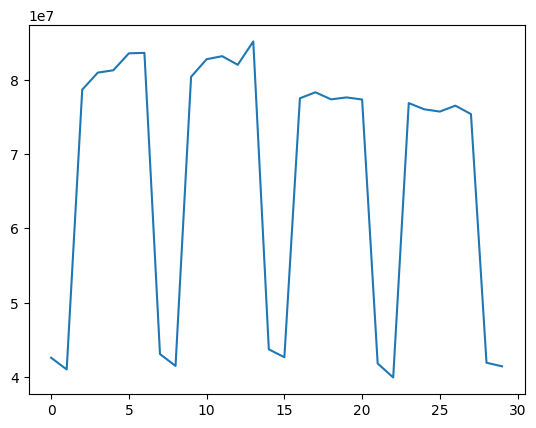

In [ ]:
plt.plot(pred)

In [ ]:
submission["forecast_value"] = pred

In [ ]:
submission.to_csv("catboost_original.csv", index=False)

In [ ]:
train_after_covid.shift(29)

,date,forecast_value
0,NaT,NaN
1,NaT,NaN
2,NaT,NaN
3,NaT,NaN
4,NaT,NaN
...,...,...
852,2024-05-28,1.003180e+08
853,2024-05-29,9.832966e+07
854,2024-05-30,1.000403e+08
855,2024-05-31,9.813730e+07


In [ ]:
train_after_covid

,date,forecast_value
0,2022-02-25,2.784901e+07
1,2022-02-26,4.872699e+06
2,2022-02-27,3.604619e+06
3,2022-02-28,2.415991e+07
4,2022-03-01,2.112790e+07
...,...,...
852,2024-06-26,0.000000e+00
853,2024-06-27,0.000000e+00
854,2024-06-28,0.000000e+00
855,2024-06-29,0.000000e+00


In [ ]:
test_training = train_after_covid.copy()
test_training["id"] = 1
df_rolled = roll_time_series(
    test_training["forecast_value"].shift(30).loc[30:],
    column_id="id",
    column_sort="date",
    max_timeshift=30,
    min_timeshift=5,
    rolling_direction=1,
)

df_rolled.head(35)

AttributeError: The given column for the id is not present in the data.

In [ ]:
test_training.shift(30)

,date,forecast_value,id
0,NaT,NaN,NaN
1,NaT,NaN,NaN
2,NaT,NaN,NaN
3,NaT,NaN,NaN
4,NaT,NaN,NaN
...,...,...,...
852,2024-05-27,1.007527e+08,1.0
853,2024-05-28,1.003180e+08,1.0
854,2024-05-29,9.832966e+07,1.0
855,2024-05-30,1.000403e+08,1.0


In [ ]:
df_rolled[df_rolled["id"] == df_rolled.loc[1398]["id"]]

,date,forecast_value,id
1394,2022-02-25,2.784901e+07,"(1, 2022-03-06 00:00:00)"
1395,2022-02-26,4.872699e+06,"(1, 2022-03-06 00:00:00)"
1396,2022-02-27,3.604619e+06,"(1, 2022-03-06 00:00:00)"
1397,2022-02-28,2.415991e+07,"(1, 2022-03-06 00:00:00)"
1398,2022-03-01,2.112790e+07,"(1, 2022-03-06 00:00:00)"
1399,2022-03-02,2.119904e+07,"(1, 2022-03-06 00:00:00)"
1400,2022-03-03,2.147315e+07,"(1, 2022-03-06 00:00:00)"
1401,2022-03-04,2.092735e+07,"(1, 2022-03-06 00:00:00)"
1402,2022-03-05,2.830259e+07,"(1, 2022-03-06 00:00:00)"
1403,2022-03-06,1.223718e+07,"(1, 2022-03-06 00:00:00)"


,date,forecast_value,id
5070,2022-02-25,2.784901e+07,"(1, 2022-03-27 00:00:00)"
5071,2022-02-26,4.872699e+06,"(1, 2022-03-27 00:00:00)"
5072,2022-02-27,3.604619e+06,"(1, 2022-03-27 00:00:00)"
5073,2022-02-28,2.415991e+07,"(1, 2022-03-27 00:00:00)"
5074,2022-03-01,2.112790e+07,"(1, 2022-03-27 00:00:00)"
...,...,...,...
81037,2024-06-26,0.000000e+00,"(1, 2024-06-30 00:00:00)"
81038,2024-06-27,0.000000e+00,"(1, 2024-06-30 00:00:00)"
81039,2024-06-28,0.000000e+00,"(1, 2024-06-30 00:00:00)"
81040,2024-06-29,0.000000e+00,"(1, 2024-06-30 00:00:00)"


In [ ]:
# Sample DataFrame with date and value
data = {
    "date": pd.date_range(start="2023-01-01", periods=100, freq="D"),
    "value": np.random.rand(100),
}
df = pd.DataFrame(data)

# Define the lags you want to create
lags = [30, 37]

# Create lagged features
for lag in lags:
    df[f"value_lag_{lag}"] = df["value"].shift(lag)

# Drop the rows where any lagged value is NaN (due to the shift)
df = df.dropna()

# Prepare the dataframe for tsfresh by adding 'id' and 'time' columns
# Here, we assume that all data belongs to one time series (id=1)
df["id"] = 1
df["time"] = np.arange(len(df))

# Melt the dataframe to long format for tsfresh
df_long = pd.melt(
    df, id_vars=["id", "time"], value_vars=[f"value_lag_{lag}" for lag in lags]
)

# Use tsfresh to extract features from the lagged columns
extracted_features = extract_features(df_long, column_id="id", column_sort="time")

# View the extracted features
print(extracted_features.head())

/home/seara/Desktop/Github/mtc-time-series/.venv/lib/python3.12/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


ValueError: value_name (value) cannot match an element in the DataFrame columns.